## Brain Templates - Colab Workflow - ImageNet

go/brain-templates-colab-imagenet

Colab with some example code for a workflow using go/brain-templates-doc.

It's recommended to use a *Brain Frameworks JellyDonut* runtime stated via the Colab UI
[screenshot](https://screenshot.googleplex.com/FynwAHhEymf). The CPU runtime might not have enough memory.

Alternatively you can follow the instructions on go/ml-colab to start a custom
runtime which allows you to:
- Co-locate the runtime in the same cluster as your data or checkpoints are written.
- Change the requirements fo RAM or connected accelerators.
- Add additional BUILD dependencies to the kernel.
- You can start the runtime via xmanager.

## Imports

The *Brain Frameworks* runtime includes many packages already. If you don't change these you can import them directly from the runtime.

For your project you can leverage go/colab-adhoc-import and `importlib.reload` to load code directly from your CitC with your local changes.

In [1]:
import importlib
import os
import time

from colabtools import adhoc_import
from colabtools import googlelog
import flax
from flax import linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

# Hide any GPUs form TensorFlow. Otherwise TF might reserve memory and make
# it unavailable to JAX.
tf.config.experimental.set_visible_devices([], "GPU")

print("JAX devices:\n" + "\n".join([repr(d) for d in jax.devices()]))

JAX devices:
cuda(id=0)


In [2]:
# Reload this cell when you change your code.

client_name = "lsm_toy_example"  #@param {"type": "string"}

if client_name:
  import_scope = adhoc_import.Google3CitcClient(client_name, behavior="fallback")
else:
  import_scope = adhoc_import.Google3Head()

with import_scope:
  from google3.experimental.largesensormodels.toy_datasets.imagenet import input_pipeline  # CHANGEME
  from google3.experimental.largesensormodels.toy_datasets.imagenet import resnet_v1  # CHANGEME
  from google3.experimental.largesensormodels.toy_datasets.imagenet import train  # CHANGEME
  from google3.experimental.largesensormodels.toy_datasets.imagenet.configs import default  # CHANGEME
  importlib.reload(default)
  importlib.reload(input_pipeline)
  importlib.reload(resnet_v1)
  importlib.reload(train)

## Inspect input pipeline

Quickly visualize outputs from your input pipeline using `tfds.visualization.show_examples`. For large datasets you can use `take(n).cache()` to cache the first `n` elements of the dataset in memory.

In [3]:
imagenet_builder = tfds.builder("imagenet2012")
info = imagenet_builder.info

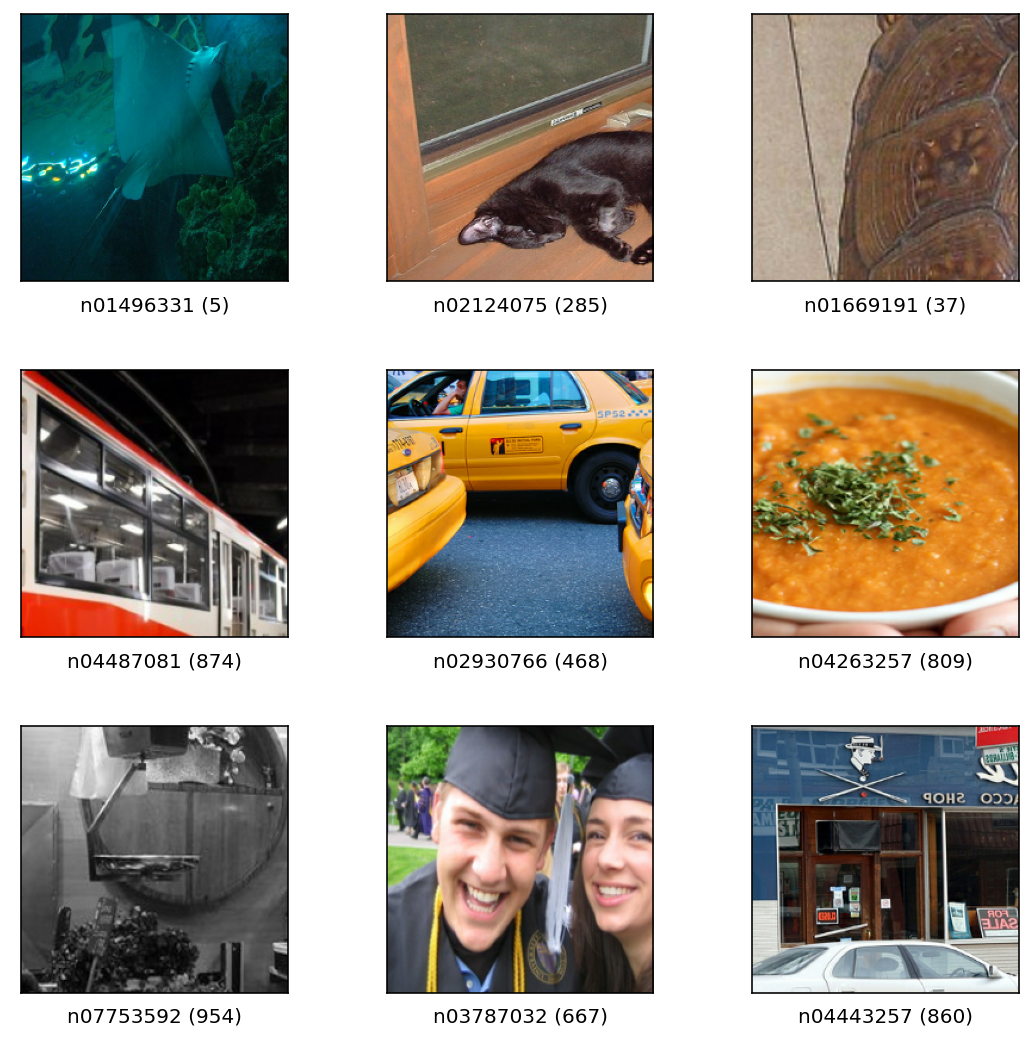

In [4]:
train_loader, eval_loader = input_pipeline.create_datasets(
    config=default.get_config(), seed=0
)
train_iter = iter(train_loader)
_ = tfds.visualization.show_examples(train_iter, imagenet_builder.info, is_batched=True)

## Running a single training step

Performing all the setup and running training + evaluation can be very slow (especially on CPU). To test our training loop quickly we use a few tricks:

- Change the config to use a smaller model.
- Change the config to use batch size 8 and only run a single training step.

These are obviousily a lot of simplication. **The idea here is to test the training loop, not to train a real model.**

In [5]:
config = default.get_config()
config.model_name = "resnet18"
config.per_device_batch_size = 1
config.num_train_steps = 1
config.num_eval_steps = 1
config.num_epochs = 1
config.warmup_epochs = 0
print(config)

checkpoint_every_steps: 5000
eval_every_steps: 5000
eval_pad_last_batch: true
learning_rate: 0.1
learning_rate_schedule: cosine
log_loss_every_steps: 500
model_name: resnet18
num_epochs: 1.0
num_eval_steps: 1
num_train_steps: 1
per_device_batch_size: 1
seed: null
sgd_momentum: 0.9
trial: 0
warmup_epochs: 0.0
weight_decay: 0.0001



In [6]:
# Re-create datasets with possibly updated config.
train_loader, eval_loader = input_pipeline.create_datasets(
    config=config, seed=0
)

In [7]:
workdir = f"/tmp/workdir_{int(time.time())}"

In [8]:
def drop_hlo(log_event):
  return log_event.source_basename != 'deepsea_compiler_base.cc'

with googlelog.CaptureLog(filter_fun=drop_hlo):
  checkpointed_state = train.train_and_evaluate(config, workdir)

I0510 10:22:07.048659   74452 train.py:402] Using random seed [4294967295 4294967295].
I0510 10:22:07.048734   74452 train.py:407] num_train_steps=1, steps_per_epoch=1
I0510 10:22:07.127358   74452 operation.cc:381]  2024/05/10-10:22:07.126276       0.001084 create_dir (trace_id: 9fb2b57cd13b9dfd span_id: 174e191a4cea2c3e parent_span_id: 0000000000000000 mask: 76000800 initiator: 0/<missing> probability: 0.000000)
            10:22:07.126279        .     2 ... file:/cns/oi-d/home/xliucs/jax/compilation_cache/ttl=14d/rs=10.4:sl=80M
            10:22:07.126312        .    33 ... CreateDir client op starts with 1 requests
            10:22:07.126324        .    12 ... targets [ 05/home/xliucs/jax/compilation_cache/ttl=14d/ ] <
                                            ...>
            10:22:07.126333        .     9 ... start colossus_namespace.CreateDir for cell oi-d
            10:22:07.126361        .    28 ... Found location in cache
            10:22:07.126371        .    11 ... Loo

## Inference

The training step above created a checkpoint. We will use it to demonstrate inference. In practice you can also load from CNS. Just be careful to run your Colab in the same cell as your checkpoints are saved.

In [9]:
# Use checkpoint of host 0.
train_state = train.load_last_state(workdir, checkpointed_state)
variables = {"params": flax.core.FrozenDict(train_state.params),
             "batch_stats": flax.core.FrozenDict(train_state.batch_stats)}
model = resnet_v1.ResNet18(num_classes=1000)

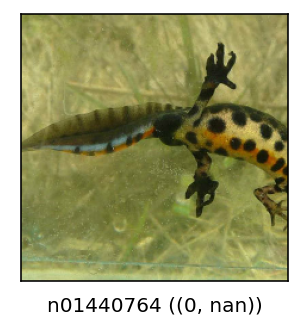

In [10]:
@jax.pmap
def predict(image):
  logits = model.apply(variables, image, mutable=False, train=False)
  # Return predicted class and confidence.
  return logits.argmax(axis=-1), nn.softmax(logits, axis=-1).max(axis=-1)

batch = train.reshape_batch(next(iter(eval_loader)))
batch["label"] = predict(batch["image"])
ds = tf.data.Dataset.from_tensor_slices(batch)
# Hack to show prediction and confidence.
info.features["label"].int2str = (
    lambda x: info.features["label"]._int2str[x[0]])
# This will show len(jax.devices()) * per_device_batch_size images.
# Remove two level of batches : [len(jax.devices()), per_device_batch_size].
_ = tfds.visualization.show_examples(ds, info, is_batched=True)